In [2]:
#In May 2025, torch_geometric is not installed On Colab, might change in the future.
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/ColabNotebooks/STAT_461")

Mounted at /content/drive


In [ ]:
!ls

base  EuclidNet_So2.ipynb  EuclidNet_VN_So2.ipynb  Files
data  EuclidNet_So3.ipynb  EuclidNet_VN_So3.ipynb  VN


In [3]:
import os, gc, joblib, math, pandas as pd, numpy as np
from glob import glob
from tqdm.auto import tqdm, trange
from typing import Union, List
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
import torch.optim as optim
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from scipy.optimize import root_scalar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
pd.set_option("display.max_columns", 100)

# project-specific paths
PATH_DATA0 = "./data/00.01"   # graphs_train/val/test.pkl live here
PATH_DATA  = "./data/00.02"   # where we save models + stats
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Using device: cuda


In [ ]:
CRITERION     = nn.BCELoss()
LR            = 1e-3
TOLERANCE     = 20
LR_TOLERANCE  = 5
MAX_EPOCHS    = 100
BATCH_SIZE    = 2

In [ ]:
loader_train = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = True)
loader_val = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = False)
loader_test = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = False)

# Util Functions

In [ ]:
#Adapted from https://github.com/athete/equivariant-tracking
def norm(x: Tensor) -> Tensor:
    r"""Euclidean square norm
    `\|x\|^2 = x[0]^2+x[1]^2+x[2]^2`
    """
    x_sq = torch.pow(x, 2)
    return x_sq.sum(dim=-1)


def dot(x: Tensor, y: Tensor) -> Tensor:
    r"""Euclidean inner product
    `<x,y> = x[0]y[0]+x[1]y[1]+x[2]y[2]`
    """
    xy = x * y
    return xy.sum(dim=-1)


def psi(x: Tensor) -> Tensor:
    """`\psi(x) = sgn(x) \cdot \log(|x| + 1)`"""
    return torch.sign(x) * torch.log(torch.abs(x) + 1)

def euclidean_feats(
    edge_index: Tensor, x: Tensor, s: Union[Tensor, None]
) -> List[Tensor]:
    i, j = edge_index
    x_diff = x[i] - x[j]
    norms = norm(x_diff).unsqueeze(1)
    dots = dot(x[i], x[j]).unsqueeze(1)
    norms, dots = psi(norms), psi(dots)

    # Handle first GNN iteration
    s_cat = torch.cat([s[i], s[j]], dim=1) if s is not None else None

    return norms, dots, x_diff, s_cat

def unsorted_segment_mean(
    data: Tensor, segment_ids: Tensor, num_segments: int
) -> Tensor:
    r"""Custom PyTorch op to replicate TensorFlow's `unsorted_segment_mean`.
    Adapted from https://github.com/vgsatorras/egnn.
    """
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    count.index_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

# Model Architecture

In [ ]:
#Adapted from https://github.com/athete/equivariant-tracking
class EB(nn.Module):
    def __init__(self, n_hidden: int = 32, c_weight: float = 1.0) -> None:
        super(EB, self).__init__()
        # dims for norm & inner product
        self.n_edge_attributes = 2
        # Controls the scale of x during updates
        self.c_weight = c_weight

        # MLP to create the message
        self.phi_e = nn.Sequential(
            nn.Linear(self.n_edge_attributes, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
        )

        layer = nn.Linear(n_hidden, 1, bias=False)
        nn.init.xavier_uniform_(layer.weight, gain=0.001)
        # MLP to generate attention weights
        self.phi_x = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.ReLU(), layer)

        # MLP to generate weights for the messages
        self.phi_m = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())

    def message(self, norms, dots):
        m_ij = torch.cat([norms, dots], dim=1)
        m_ij = self.phi_e(m_ij)
        w = self.phi_m(m_ij)
        m_ij = m_ij * w
        return m_ij

    def x_model(self, x, edge_index, x_diff, m):
        i, j = edge_index
        update_val = x_diff * self.phi_x(m)
        # LorentzNet authors clamp the update tensor as a precautionary measure
        update_val = torch.clamp(update_val, min=-100, max=100)
        x_agg = unsorted_segment_mean(update_val, i, num_segments=x.size(0))
        x = x + x_agg * self.c_weight
        return x

    def forward(self, x, edge_index):
        norms, dots, x_diff, _ = euclidean_feats(edge_index, x, None)
        m = self.message(norms, dots)
        x_tilde = self.x_model(x, edge_index, x_diff, m)
        return x_tilde, m


class EuclidNet(nn.Module):
    def __init__(self, hparams) -> None:
        super(EuclidNet, self).__init__()

        self.hparams = hparams
        self.n_input = hparams["n_input"]
        self.n_output = hparams["n_output"]
        self.n_hidden = hparams["n_hidden"]
        self.n_layers = hparams["n_layers"]
        self.c_weight = hparams["c_weight"]

        self.EBs = nn.ModuleList(
            [
                EB(n_hidden=self.n_hidden, c_weight=self.c_weight)
                for _ in range(self.n_layers)
            ]
        )

        # MLP to produce edge weights
        edge_mlp_input_dim = 2 * self.n_input + self.n_hidden
        layers = [nn.Linear(edge_mlp_input_dim, self.n_hidden),
            nn.ReLU()]

        # Change of hidden layers
        if n_layers>=2:
          for _ in range(n_layers - 1):
              layers.append(nn.Linear(self.n_hidden, self.n_hidden))
              layers.append(nn.ReLU())
        layers.append(nn.Linear(self.n_hidden, self.n_output))
        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index):
        for i in range(self.n_layers):
            x, m_ij = self.EBs[i](x, edge_index)
        m = torch.cat([x[edge_index[1]], x[edge_index[0]], m_ij], dim=1)
        return torch.sigmoid(self.edge_mlp(m))

# Helper Functions

In [ ]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

def evaluate(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index)
            preds.append(output)
            actuals.append(batch.y)
        preds = torch.cat(preds)
        actuals = torch.cat(actuals)
        acc = ((preds > 0.5) == (actuals > 0.5)).type(torch.float).mean().item()
        entropy = CRITERION(preds, actuals.float()).item()
    model.train()
    return preds.cpu().numpy(), actuals.cpu().numpy(), acc, entropy

def train_epoch(model, loader_train, optimizer):
    model.train()
    train_loss = 0.0
    for batch in tqdm(loader_train, leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()
        # EuclidNet only need x & edge_index
        output = model(batch.x, batch.edge_index)
        loss = CRITERION(output, batch.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(loader_train)
    return train_loss

# Training Loop Function

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Training n_layers=3, target_params=100000
Actual amount of parameter: 100884
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.8140 |    0.3721 |   0.8495 |    0.8535 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.6658 |    0.3073 |   0.8578 |    0.8619 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5756 |    0.2986 |   0.8593 |    0.8625 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5536 |    0.2743 |   0.8683 |    0.8713 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5466 |    0.2742 |   0.8687 |    0.8719 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5411 |    0.2697 |   0.8703 |    0.8734 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5367 |    0.2697 |   0.8701 |    0.8730 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.5350 |    0.2674 |   0.8712 |    0.8744 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.5335 |    0.2681 |   0.8716 |    0.8744


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.5316 |    0.2672 |   0.8713 |    0.8744 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.5283 |    0.2641 |   0.8730 |    0.8759 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.5268 |    0.2646 |   0.8726 |    0.8754


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.5256 |    0.2700 |   0.8707 |    0.8738


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.5258 |    0.2629 |   0.8736 |    0.8765 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.5233 |    0.2618 |   0.8739 |    0.8768 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.5222 |    0.2603 |   0.8745 |    0.8775 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.5202 |    0.2616 |   0.8742 |    0.8774


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.5203 |    0.2609 |   0.8744 |    0.8776


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.5187 |    0.2591 |   0.8750 |    0.8778 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.5174 |    0.2589 |   0.8750 |    0.8780 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.5171 |    0.2605 |   0.8741 |    0.8774


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.5161 |    0.2596 |   0.8751 |    0.8784


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.5144 |    0.2577 |   0.8758 |    0.8789 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.5147 |    0.2574 |   0.8758 |    0.8788 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.5133 |    0.2614 |   0.8744 |    0.8772


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.5130 |    0.2566 |   0.8759 |    0.8789 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.5119 |    0.2566 |   0.8759 |    0.8791 *


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.5118 |    0.2605 |   0.8746 |    0.8778


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.5113 |    0.2589 |   0.8757 |    0.8787


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.5107 |    0.2556 |   0.8761 |    0.8790 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.5100 |    0.2579 |   0.8759 |    0.8788


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.5106 |    0.2566 |   0.8762 |    0.8790


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.5096 |    0.2591 |   0.8759 |    0.8789


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.5099 |    0.2576 |   0.8757 |    0.8790


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.5092 |    0.2659 |   0.8716 |    0.8744
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.5031 |    0.2528 |   0.8777 |    0.8807 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.5023 |    0.2528 |   0.8776 |    0.8806 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.5020 |    0.2526 |   0.8777 |    0.8806 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.5020 |    0.2527 |   0.8776 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.5017 |    0.2533 |   0.8776 |    0.8806


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.5019 |    0.2535 |   0.8776 |    0.8807


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.5018 |    0.2527 |   0.8777 |    0.8807


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.5016 |    0.2526 |   0.8777 |    0.8808 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.5018 |    0.2525 |   0.8777 |    0.8806 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.5013 |    0.2527 |   0.8777 |    0.8808


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.5016 |    0.2527 |   0.8777 |    0.8806


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.5013 |    0.2523 |   0.8777 |    0.8807 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.5009 |    0.2522 |   0.8779 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.5012 |    0.2521 |   0.8778 |    0.8809 *


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.5016 |    0.2531 |   0.8775 |    0.8807


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.5010 |    0.2529 |   0.8778 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.5008 |    0.2532 |   0.8778 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.5007 |    0.2521 |   0.8779 |    0.8808


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.5006 |    0.2526 |   0.8777 |    0.8808
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.5000 |    0.2521 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4998 |    0.2519 |   0.8780 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.5004 |    0.2520 |   0.8779 |    0.8808


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.5003 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4996 |    0.2520 |   0.8779 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.5002 |    0.2519 |   0.8779 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4997 |    0.2519 |   0.8780 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.5000 |    0.2521 |   0.8779 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4996 |    0.2519 |   0.8780 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.5002 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4999 |    0.2520 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.5000 |    0.2519 |   0.8780 |    0.8809
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4997 |    0.2518 |   0.8780 |    0.8809 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4994 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4997 |    0.2521 |   0.8779 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4994 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4998 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4996 |    0.2519 |   0.8780 |    0.8810
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4997 |    0.2521 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4996 |    0.2518 |   0.8780 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4998 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4999 |    0.2521 |   0.8780 |    0.8811


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4997 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4996 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4994 |    0.2519 |   0.8780 |    0.8810
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4995 |    0.2521 |   0.8780 |    0.8811


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.5000 |    0.2518 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4999 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4993 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4995 |    0.2519 |   0.8780 |    0.8809
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4994 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.5001 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4997 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4996 |    0.2518 |   0.8780 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.5001 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.5000 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.5002 |    0.2520 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.5002 |    0.2519 |   0.8780 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4999 |    0.2520 |   0.8780 |    0.8811


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4998 |    0.2519 |   0.8780 |    0.8810
Early stop at 94 round


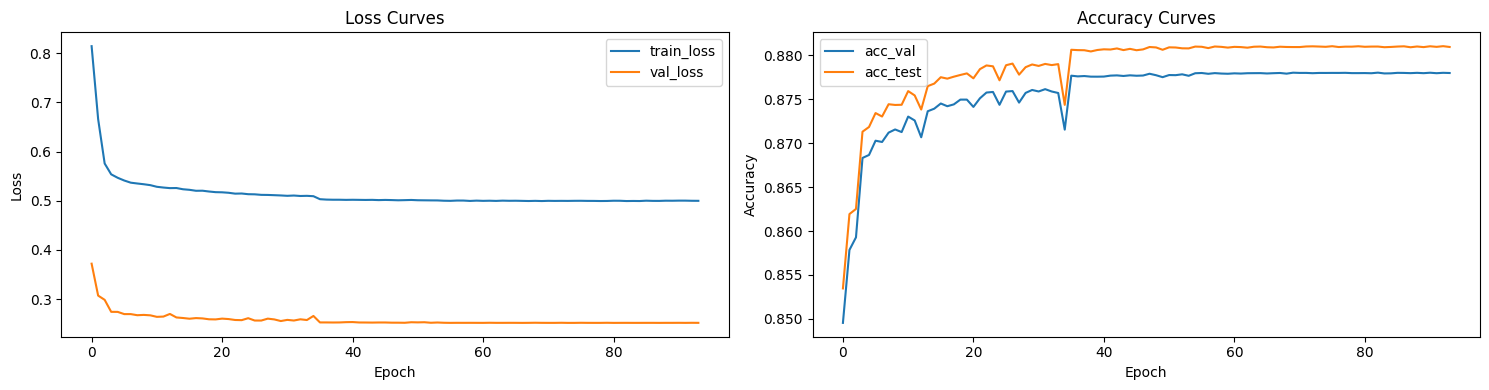

Training n_layers=3, target_params=500000
Actual amount of parameter: 500764
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.7522 |    0.3196 |   0.8557 |    0.8591 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.5879 |    0.2908 |   0.8627 |    0.8659 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5573 |    0.2781 |   0.8668 |    0.8699 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5489 |    0.2772 |   0.8677 |    0.8709 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5437 |    0.2729 |   0.8692 |    0.8723 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5401 |    0.2712 |   0.8690 |    0.8721 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5379 |    0.2678 |   0.8705 |    0.8735 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.5339 |    0.2716 |   0.8687 |    0.8720


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.5341 |    0.2653 |   0.8716 |    0.8747 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.5314 |    0.2681 |   0.8707 |    0.8740


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.5286 |    0.2656 |   0.8719 |    0.8750


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.5282 |    0.2644 |   0.8729 |    0.8754 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.5259 |    0.2622 |   0.8737 |    0.8767 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.5237 |    0.2622 |   0.8737 |    0.8768


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.5237 |    0.2631 |   0.8738 |    0.8768


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.5213 |    0.2654 |   0.8729 |    0.8757


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.5214 |    0.2644 |   0.8728 |    0.8758


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.5173 |    0.2638 |   0.8734 |    0.8764
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.5091 |    0.2559 |   0.8767 |    0.8793 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.5080 |    0.2558 |   0.8768 |    0.8794 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.5082 |    0.2555 |   0.8770 |    0.8797 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.5080 |    0.2566 |   0.8763 |    0.8790


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.5074 |    0.2557 |   0.8770 |    0.8797


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.5079 |    0.2551 |   0.8769 |    0.8797 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.5069 |    0.2552 |   0.8768 |    0.8794


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.5066 |    0.2549 |   0.8772 |    0.8799 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.5061 |    0.2549 |   0.8771 |    0.8798 *


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.5063 |    0.2546 |   0.8773 |    0.8800 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.5059 |    0.2548 |   0.8772 |    0.8800


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.5058 |    0.2550 |   0.8769 |    0.8796


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.5064 |    0.2551 |   0.8769 |    0.8796


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.5056 |    0.2554 |   0.8771 |    0.8799


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.5053 |    0.2542 |   0.8775 |    0.8801 *


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.5053 |    0.2552 |   0.8770 |    0.8799


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.5051 |    0.2550 |   0.8769 |    0.8796


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.5046 |    0.2541 |   0.8775 |    0.8803 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.5039 |    0.2538 |   0.8775 |    0.8803 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.5042 |    0.2544 |   0.8771 |    0.8800


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.5042 |    0.2536 |   0.8775 |    0.8803 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.5042 |    0.2539 |   0.8777 |    0.8802


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.5031 |    0.2542 |   0.8776 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.5037 |    0.2561 |   0.8771 |    0.8800


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.5026 |    0.2536 |   0.8776 |    0.8802 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.5029 |    0.2556 |   0.8771 |    0.8800


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.5032 |    0.2529 |   0.8776 |    0.8805 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.5025 |    0.2538 |   0.8778 |    0.8806


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.5023 |    0.2535 |   0.8778 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.5027 |    0.2530 |   0.8778 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.5020 |    0.2529 |   0.8777 |    0.8805 *


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.5018 |    0.2529 |   0.8778 |    0.8807 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.5018 |    0.2538 |   0.8776 |    0.8804


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.5013 |    0.2548 |   0.8776 |    0.8803


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.5020 |    0.2532 |   0.8779 |    0.8808


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.5012 |    0.2538 |   0.8777 |    0.8808


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.5013 |    0.2532 |   0.8779 |    0.8807
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.5002 |    0.2522 |   0.8781 |    0.8809 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4998 |    0.2521 |   0.8782 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4997 |    0.2522 |   0.8781 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4998 |    0.2522 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.5006 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4994 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4997 |    0.2521 |   0.8782 |    0.8809
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4994 |    0.2521 |   0.8782 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4995 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4995 |    0.2521 |   0.8781 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4994 |    0.2521 |   0.8781 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4994 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4995 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4996 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4997 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4997 |    0.2522 |   0.8783 |    0.8809
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4996 |    0.2521 |   0.8781 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4992 |    0.2525 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4995 |    0.2520 |   0.8782 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4991 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4994 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4993 |    0.2522 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4991 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4998 |    0.2521 |   0.8782 |    0.8810
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4993 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4994 |    0.2520 |   0.8781 |    0.8810 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4996 |    0.2523 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4998 |    0.2521 |   0.8780 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4994 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4996 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4997 |    0.2521 |   0.8782 |    0.8810
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4991 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4992 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4994 |    0.2521 |   0.8781 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4993 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4997 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4999 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4999 |    0.2521 |   0.8781 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4992 |    0.2524 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4991 |    0.2525 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4995 |    0.2524 |   0.8782 |    0.8809


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4993 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.4995 |    0.2521 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.4994 |    0.2522 |   0.8782 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.4996 |    0.2521 |   0.8782 |    0.8810


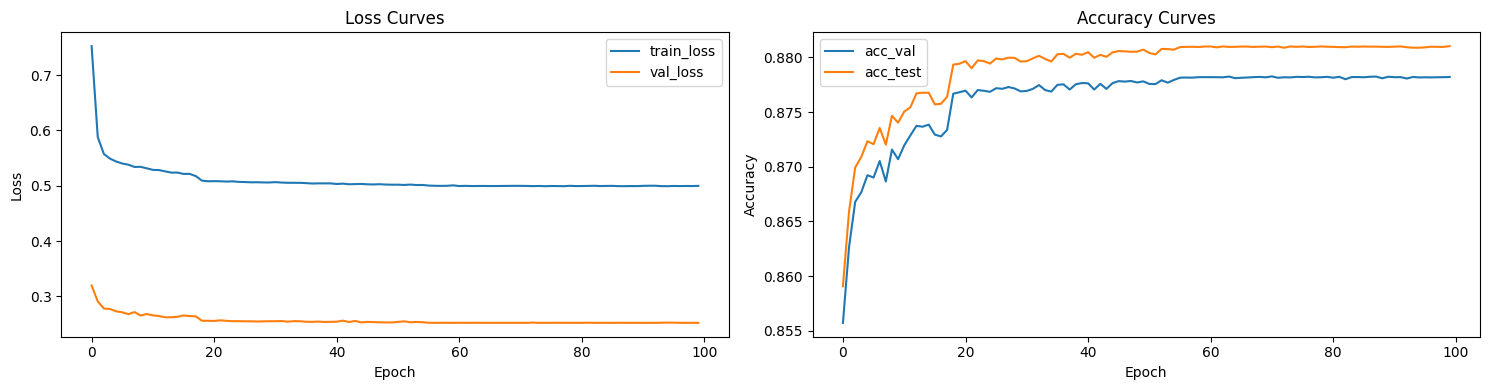

Training n_layers=3, target_params=1000000
Actual amount of parameter: 997307
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.8037 |    0.3875 |   0.8494 |    0.8533 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.6982 |    0.3260 |   0.8576 |    0.8613 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.6259 |    0.2923 |   0.8782 |    0.8819 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5488 |    0.2646 |   0.8871 |    0.8901 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5182 |    0.2581 |   0.8900 |    0.8930 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5069 |    0.2511 |   0.8959 |    0.8988 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.4908 |    0.2486 |   0.8992 |    0.9022 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.4772 |    0.2352 |   0.9025 |    0.9056 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.4707 |    0.2377 |   0.9021 |    0.9053


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.4669 |    0.2395 |   0.9016 |    0.9047


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.4606 |    0.2300 |   0.9049 |    0.9082 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.4590 |    0.2287 |   0.9056 |    0.9089 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.4534 |    0.2318 |   0.9047 |    0.9078


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.4504 |    0.2255 |   0.9064 |    0.9096 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.4473 |    0.2238 |   0.9078 |    0.9113 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.4426 |    0.2246 |   0.9079 |    0.9112


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.4412 |    0.2200 |   0.9095 |    0.9127 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.4365 |    0.2233 |   0.9086 |    0.9114


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.4350 |    0.2191 |   0.9097 |    0.9127 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.4305 |    0.2160 |   0.9100 |    0.9133 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.4318 |    0.2204 |   0.9095 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.4277 |    0.2187 |   0.9099 |    0.9130


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.4294 |    0.2203 |   0.9084 |    0.9115


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.4265 |    0.2139 |   0.9114 |    0.9142 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.4252 |    0.2158 |   0.9102 |    0.9133


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4236 |    0.2109 |   0.9124 |    0.9152 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4226 |    0.2145 |   0.9110 |    0.9139


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.4223 |    0.2107 |   0.9123 |    0.9153 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4175 |    0.2130 |   0.9120 |    0.9147


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4218 |    0.2093 |   0.9126 |    0.9156 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4169 |    0.2110 |   0.9128 |    0.9155


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4166 |    0.2076 |   0.9134 |    0.9160 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4160 |    0.2124 |   0.9117 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4140 |    0.2175 |   0.9097 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4129 |    0.2096 |   0.9131 |    0.9158


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4124 |    0.2079 |   0.9132 |    0.9162


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4118 |    0.2100 |   0.9127 |    0.9154
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.3998 |    0.2030 |   0.9150 |    0.9176 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.3977 |    0.2021 |   0.9153 |    0.9179 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.3970 |    0.2018 |   0.9153 |    0.9180 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.3966 |    0.2015 |   0.9155 |    0.9180 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.3961 |    0.2023 |   0.9152 |    0.9176


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.3954 |    0.2012 |   0.9156 |    0.9181 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.3952 |    0.2022 |   0.9153 |    0.9180


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.3951 |    0.2011 |   0.9156 |    0.9181 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.3946 |    0.2008 |   0.9157 |    0.9183 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.3947 |    0.2011 |   0.9157 |    0.9182


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.3945 |    0.2010 |   0.9157 |    0.9182


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.3939 |    0.2008 |   0.9157 |    0.9181 *


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.3931 |    0.2009 |   0.9157 |    0.9183


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.3940 |    0.2004 |   0.9158 |    0.9183 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.3938 |    0.2004 |   0.9158 |    0.9183 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.3941 |    0.2008 |   0.9158 |    0.9183


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.3931 |    0.2005 |   0.9159 |    0.9183


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.3935 |    0.2008 |   0.9157 |    0.9184


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.3932 |    0.2002 |   0.9159 |    0.9184 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.3933 |    0.2003 |   0.9159 |    0.9183


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.3927 |    0.2023 |   0.9150 |    0.9174


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.3922 |    0.2002 |   0.9159 |    0.9184


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.3927 |    0.2002 |   0.9160 |    0.9185 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.3917 |    0.1997 |   0.9162 |    0.9187 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.3921 |    0.1997 |   0.9161 |    0.9186 *


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.3922 |    0.2003 |   0.9158 |    0.9183


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.3913 |    0.2000 |   0.9161 |    0.9185


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.3916 |    0.2000 |   0.9161 |    0.9186


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.3913 |    0.2000 |   0.9159 |    0.9184


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.3922 |    0.1996 |   0.9161 |    0.9186 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.3914 |    0.1993 |   0.9163 |    0.9187 *


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.3912 |    0.1994 |   0.9162 |    0.9187


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.3917 |    0.2000 |   0.9160 |    0.9185


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.3907 |    0.2009 |   0.9155 |    0.9180


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.3915 |    0.1999 |   0.9161 |    0.9186


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.3911 |    0.1993 |   0.9163 |    0.9189 *


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.3901 |    0.1993 |   0.9163 |    0.9187


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.3913 |    0.1994 |   0.9162 |    0.9188


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.3909 |    0.2003 |   0.9159 |    0.9185


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.3906 |    0.1994 |   0.9162 |    0.9188


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.3907 |    0.2003 |   0.9159 |    0.9185
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.3883 |    0.1986 |   0.9164 |    0.9189 *


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.3879 |    0.1986 |   0.9165 |    0.9189 *


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.3878 |    0.1985 |   0.9165 |    0.9190 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.3872 |    0.1985 |   0.9165 |    0.9190 *


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.3878 |    0.1985 |   0.9165 |    0.9189


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.3875 |    0.1986 |   0.9165 |    0.9189


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.3878 |    0.1985 |   0.9165 |    0.9190 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.3878 |    0.1985 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.3874 |    0.1985 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.3872 |    0.1984 |   0.9166 |    0.9190 *


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.3876 |    0.1984 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.3872 |    0.1984 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.3873 |    0.1985 |   0.9165 |    0.9189


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.3874 |    0.1986 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.3877 |    0.1985 |   0.9165 |    0.9190
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.3871 |    0.1985 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.3874 |    0.1984 |   0.9165 |    0.9189


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.3872 |    0.1984 |   0.9165 |    0.9189


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.3873 |    0.1984 |   0.9165 |    0.9190


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.3875 |    0.1984 |   0.9165 |    0.9189
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.3866 |    0.1984 |   0.9166 |    0.9190 *


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.3872 |    0.1984 |   0.9165 |    0.9189


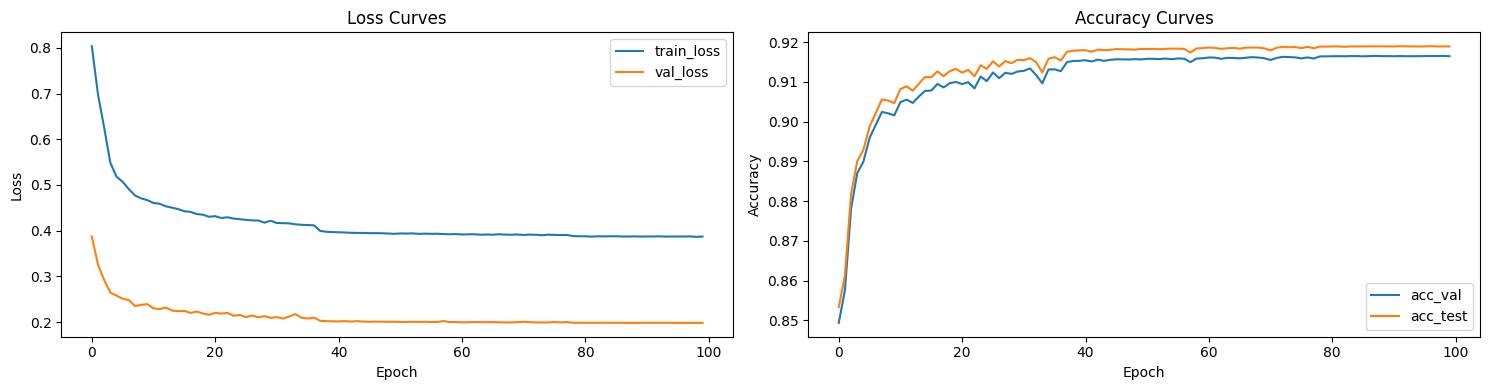

  0%|          | 0/3 [00:00<?, ?it/s]

Training n_layers=4, target_params=100000
Actual amount of parameter: 101075
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.7452 |    0.3092 |   0.8656 |    0.8689 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.5862 |    0.2803 |   0.8748 |    0.8781 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5464 |    0.2674 |   0.8788 |    0.8818 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5281 |    0.2622 |   0.8816 |    0.8844 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5201 |    0.2593 |   0.8845 |    0.8872 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5130 |    0.2553 |   0.8880 |    0.8905 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5030 |    0.2519 |   0.8900 |    0.8926 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.4974 |    0.2481 |   0.8917 |    0.8945 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.4896 |    0.2473 |   0.8930 |    0.8956 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.4864 |    0.2423 |   0.8948 |    0.8976 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.4833 |    0.2410 |   0.8961 |    0.8990 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.4804 |    0.2439 |   0.8954 |    0.8981


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.4756 |    0.2402 |   0.8965 |    0.8990 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.4741 |    0.2438 |   0.8951 |    0.8978


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.4717 |    0.2427 |   0.8921 |    0.8946


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.4709 |    0.2371 |   0.8984 |    0.9012 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.4680 |    0.2389 |   0.8971 |    0.9001


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.4651 |    0.2389 |   0.8986 |    0.9016


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.4626 |    0.2311 |   0.9010 |    0.9038 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.4610 |    0.2315 |   0.9009 |    0.9034


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.4578 |    0.2284 |   0.9019 |    0.9047 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.4559 |    0.2304 |   0.9008 |    0.9034


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.4557 |    0.2317 |   0.9005 |    0.9034


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.4533 |    0.2261 |   0.9037 |    0.9066 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.4504 |    0.2288 |   0.9032 |    0.9058


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4523 |    0.2287 |   0.9037 |    0.9063


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4495 |    0.2280 |   0.9027 |    0.9054


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.4501 |    0.2271 |   0.9041 |    0.9067


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4463 |    0.2229 |   0.9050 |    0.9075 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4462 |    0.2264 |   0.9046 |    0.9071


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4463 |    0.2284 |   0.9019 |    0.9048


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4455 |    0.2250 |   0.9049 |    0.9075


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4459 |    0.2252 |   0.9041 |    0.9068


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4461 |    0.2229 |   0.9046 |    0.9071
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4346 |    0.2183 |   0.9069 |    0.9093 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4329 |    0.2181 |   0.9070 |    0.9096 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4326 |    0.2178 |   0.9074 |    0.9097 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.4323 |    0.2177 |   0.9072 |    0.9096 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.4326 |    0.2177 |   0.9074 |    0.9098


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.4325 |    0.2175 |   0.9072 |    0.9098 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.4320 |    0.2175 |   0.9073 |    0.9098


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.4323 |    0.2172 |   0.9076 |    0.9100 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.4316 |    0.2175 |   0.9074 |    0.9099


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.4313 |    0.2175 |   0.9074 |    0.9099


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4316 |    0.2180 |   0.9071 |    0.9098


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4314 |    0.2169 |   0.9076 |    0.9102 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4308 |    0.2166 |   0.9077 |    0.9102 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4312 |    0.2173 |   0.9074 |    0.9099


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4310 |    0.2168 |   0.9075 |    0.9101


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4305 |    0.2171 |   0.9074 |    0.9100


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4311 |    0.2167 |   0.9078 |    0.9103


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4306 |    0.2167 |   0.9078 |    0.9102
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4293 |    0.2162 |   0.9079 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4292 |    0.2161 |   0.9079 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4288 |    0.2161 |   0.9080 |    0.9105 *


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4288 |    0.2161 |   0.9080 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4287 |    0.2162 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4286 |    0.2162 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4284 |    0.2160 |   0.9080 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4285 |    0.2160 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4287 |    0.2164 |   0.9079 |    0.9103


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4282 |    0.2161 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4283 |    0.2160 |   0.9080 |    0.9105 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4283 |    0.2161 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4285 |    0.2159 |   0.9080 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4285 |    0.2160 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4283 |    0.2161 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4285 |    0.2163 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4282 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4286 |    0.2160 |   0.9080 |    0.9105
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4284 |    0.2160 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4284 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4278 |    0.2159 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4280 |    0.2159 |   0.9081 |    0.9106


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4284 |    0.2159 |   0.9080 |    0.9105 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4287 |    0.2159 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4280 |    0.2158 |   0.9080 |    0.9105 *


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4283 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4279 |    0.2160 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4286 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4280 |    0.2160 |   0.9079 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4279 |    0.2159 |   0.9081 |    0.9105
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4282 |    0.2160 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4282 |    0.2160 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4280 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4287 |    0.2159 |   0.9081 |    0.9106


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4280 |    0.2159 |   0.9081 |    0.9105
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4282 |    0.2161 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4279 |    0.2160 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4279 |    0.2159 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4279 |    0.2161 |   0.9079 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4279 |    0.2158 |   0.9081 |    0.9105
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4280 |    0.2161 |   0.9080 |    0.9104


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4278 |    0.2158 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4284 |    0.2158 |   0.9080 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4284 |    0.2159 |   0.9081 |    0.9105


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4284 |    0.2158 |   0.9081 |    0.9105
Early stop at 97 round


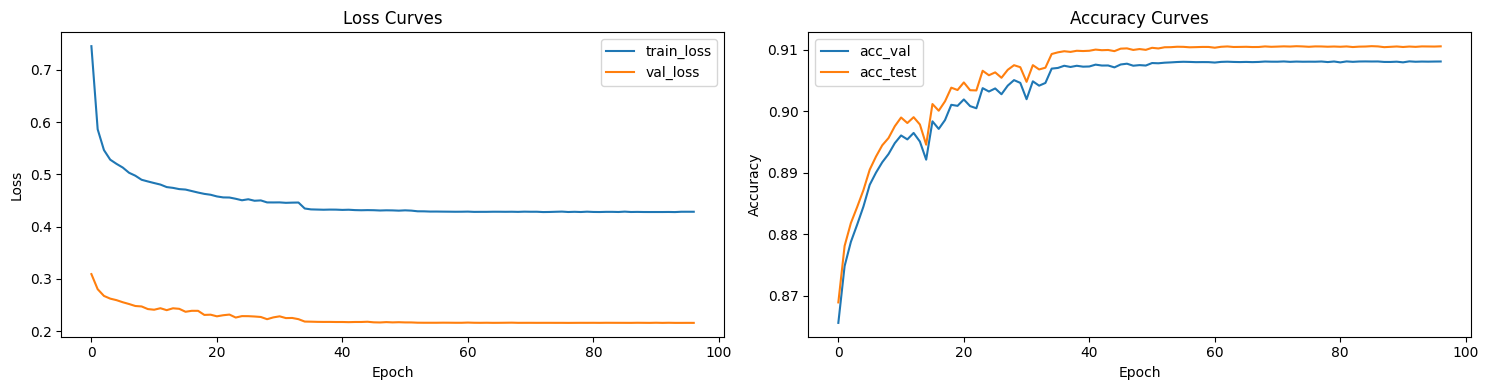

Training n_layers=4, target_params=500000
Actual amount of parameter: 498339
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.6924 |    0.2925 |   0.8703 |    0.8737 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.5607 |    0.2773 |   0.8747 |    0.8779 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5365 |    0.2699 |   0.8768 |    0.8795 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5270 |    0.2619 |   0.8803 |    0.8832 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5208 |    0.2718 |   0.8764 |    0.8798


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5164 |    0.2578 |   0.8817 |    0.8845 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5101 |    0.2526 |   0.8875 |    0.8901 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.4950 |    0.2467 |   0.8919 |    0.8944 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.4891 |    0.2455 |   0.8927 |    0.8954 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.4813 |    0.2458 |   0.8943 |    0.8974


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.4769 |    0.2423 |   0.8960 |    0.8989 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.4698 |    0.2353 |   0.8985 |    0.9012 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.4693 |    0.2378 |   0.8974 |    0.8997


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.4646 |    0.2404 |   0.8967 |    0.8995


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.4587 |    0.2299 |   0.9013 |    0.9041 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.4572 |    0.2308 |   0.9016 |    0.9043


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.4563 |    0.2265 |   0.9037 |    0.9063 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.4517 |    0.2278 |   0.9027 |    0.9055


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.4537 |    0.2279 |   0.9028 |    0.9055


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.4487 |    0.2265 |   0.9030 |    0.9057 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.4474 |    0.2246 |   0.9040 |    0.9067 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.4459 |    0.2271 |   0.9028 |    0.9057


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.4472 |    0.2218 |   0.9050 |    0.9078 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.4430 |    0.2253 |   0.9034 |    0.9061


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.4476 |    0.2236 |   0.9049 |    0.9072


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4429 |    0.2218 |   0.9049 |    0.9074


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4433 |    0.2266 |   0.9034 |    0.9060


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.4417 |    0.2211 |   0.9059 |    0.9084 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4406 |    0.2355 |   0.8990 |    0.9021


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4443 |    0.2214 |   0.9052 |    0.9075


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4392 |    0.2269 |   0.9039 |    0.9065


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4378 |    0.2215 |   0.9055 |    0.9080


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4407 |    0.2221 |   0.9044 |    0.9069
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4243 |    0.2146 |   0.9083 |    0.9107 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4226 |    0.2145 |   0.9085 |    0.9107 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4213 |    0.2141 |   0.9084 |    0.9108 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4211 |    0.2138 |   0.9083 |    0.9110 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.4210 |    0.2138 |   0.9085 |    0.9113 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.4213 |    0.2138 |   0.9086 |    0.9112


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.4203 |    0.2134 |   0.9086 |    0.9111 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.4204 |    0.2136 |   0.9088 |    0.9115


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.4201 |    0.2133 |   0.9089 |    0.9114 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.4199 |    0.2136 |   0.9084 |    0.9110


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.4192 |    0.2129 |   0.9090 |    0.9117 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4193 |    0.2132 |   0.9087 |    0.9114


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4183 |    0.2127 |   0.9091 |    0.9117 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4183 |    0.2129 |   0.9086 |    0.9113


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4182 |    0.2123 |   0.9091 |    0.9118 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4180 |    0.2125 |   0.9090 |    0.9117


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4184 |    0.2123 |   0.9092 |    0.9119 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4180 |    0.2125 |   0.9092 |    0.9118


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4177 |    0.2121 |   0.9091 |    0.9118 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4177 |    0.2125 |   0.9089 |    0.9116


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4171 |    0.2123 |   0.9093 |    0.9119


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4175 |    0.2121 |   0.9094 |    0.9121 *


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4178 |    0.2118 |   0.9093 |    0.9119 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4166 |    0.2122 |   0.9094 |    0.9120


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4164 |    0.2121 |   0.9092 |    0.9118


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4174 |    0.2123 |   0.9091 |    0.9118


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4164 |    0.2119 |   0.9093 |    0.9119


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4164 |    0.2122 |   0.9095 |    0.9122
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4140 |    0.2113 |   0.9097 |    0.9123 *


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4134 |    0.2112 |   0.9097 |    0.9123 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4138 |    0.2111 |   0.9096 |    0.9122 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4134 |    0.2112 |   0.9097 |    0.9123


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4135 |    0.2111 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4130 |    0.2110 |   0.9097 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4133 |    0.2111 |   0.9097 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4137 |    0.2110 |   0.9097 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4133 |    0.2111 |   0.9098 |    0.9123


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4131 |    0.2110 |   0.9098 |    0.9125 *


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4137 |    0.2109 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4138 |    0.2110 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4134 |    0.2111 |   0.9097 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4134 |    0.2109 |   0.9098 |    0.9125


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4131 |    0.2110 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4135 |    0.2113 |   0.9096 |    0.9123
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4129 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4133 |    0.2110 |   0.9097 |    0.9123


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4126 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4130 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4129 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4133 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4138 |    0.2109 |   0.9098 |    0.9125


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4126 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4134 |    0.2109 |   0.9097 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4136 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4127 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4136 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4135 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4127 |    0.2108 |   0.9098 |    0.9124 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4131 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4128 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4134 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4126 |    0.2109 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4127 |    0.2109 |   0.9097 |    0.9123
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4130 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.4130 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.4129 |    0.2108 |   0.9098 |    0.9124


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.4126 |    0.2109 |   0.9097 |    0.9124


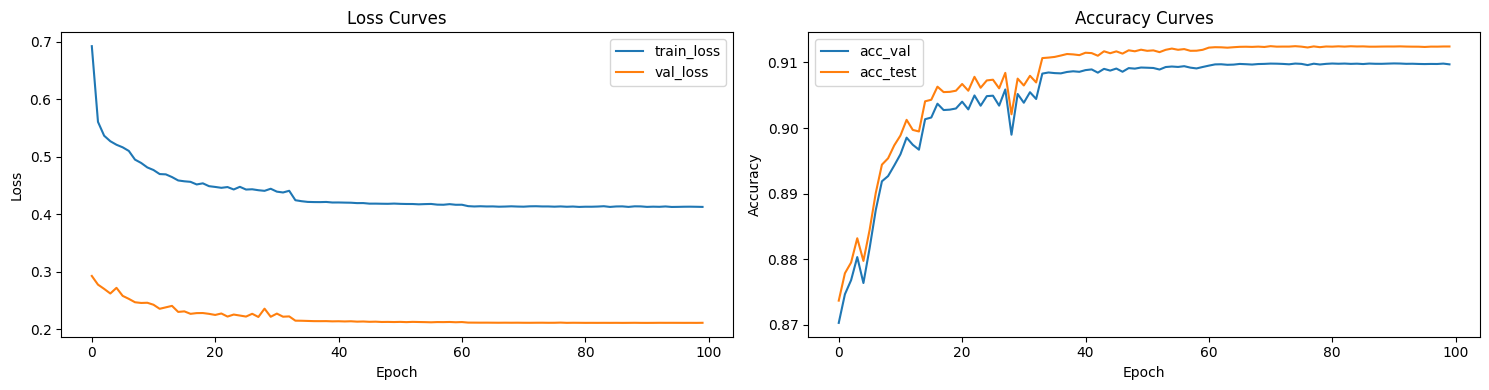

Training n_layers=4, target_params=1000000
Actual amount of parameter: 1000774
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.8045 |    0.3808 |   0.8494 |    0.8533 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.7270 |    0.3651 |   0.8519 |    0.8557 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.6863 |    0.3416 |   0.8579 |    0.8617 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.6231 |    0.2796 |   0.8804 |    0.8837 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5421 |    0.2658 |   0.8871 |    0.8901 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5205 |    0.2554 |   0.8932 |    0.8964 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5013 |    0.2507 |   0.8951 |    0.8986 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.4880 |    0.2392 |   0.9010 |    0.9040 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.4745 |    0.2438 |   0.8986 |    0.9019


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.4634 |    0.2310 |   0.9039 |    0.9071 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.4618 |    0.2273 |   0.9053 |    0.9082 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.4575 |    0.2334 |   0.9036 |    0.9065


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.4552 |    0.2301 |   0.9046 |    0.9077


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.4486 |    0.2277 |   0.9051 |    0.9084


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.4484 |    0.2229 |   0.9068 |    0.9096 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.4453 |    0.2212 |   0.9076 |    0.9104 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.4438 |    0.2237 |   0.9064 |    0.9092


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.4416 |    0.2214 |   0.9075 |    0.9101


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.4429 |    0.2192 |   0.9082 |    0.9109 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.4389 |    0.2255 |   0.9067 |    0.9093


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.4410 |    0.2196 |   0.9081 |    0.9108


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.4371 |    0.2185 |   0.9088 |    0.9111 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.4367 |    0.2195 |   0.9084 |    0.9111


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.4357 |    0.2213 |   0.9072 |    0.9100


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.4343 |    0.2179 |   0.9089 |    0.9113 *


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4331 |    0.2188 |   0.9086 |    0.9115


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4317 |    0.2183 |   0.9089 |    0.9114


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.4310 |    0.2179 |   0.9089 |    0.9118


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4309 |    0.2161 |   0.9095 |    0.9121 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4296 |    0.2189 |   0.9087 |    0.9114


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4282 |    0.2174 |   0.9093 |    0.9120


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4308 |    0.2189 |   0.9087 |    0.9115


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4312 |    0.2209 |   0.9077 |    0.9108


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4255 |    0.2177 |   0.9091 |    0.9118
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4136 |    0.2107 |   0.9114 |    0.9140 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4114 |    0.2103 |   0.9115 |    0.9142 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4112 |    0.2106 |   0.9114 |    0.9140


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.4104 |    0.2101 |   0.9116 |    0.9142 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.4105 |    0.2096 |   0.9117 |    0.9143 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.4105 |    0.2099 |   0.9116 |    0.9143


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.4108 |    0.2098 |   0.9117 |    0.9142


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.4105 |    0.2096 |   0.9118 |    0.9143


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.4093 |    0.2093 |   0.9118 |    0.9144 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.4097 |    0.2092 |   0.9119 |    0.9145 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4095 |    0.2092 |   0.9119 |    0.9145 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4085 |    0.2093 |   0.9120 |    0.9144


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4086 |    0.2095 |   0.9117 |    0.9143


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4086 |    0.2089 |   0.9120 |    0.9145 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4093 |    0.2089 |   0.9120 |    0.9147 *


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4080 |    0.2092 |   0.9119 |    0.9144


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4080 |    0.2088 |   0.9121 |    0.9146 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4082 |    0.2096 |   0.9117 |    0.9142


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4078 |    0.2089 |   0.9120 |    0.9145


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4078 |    0.2085 |   0.9121 |    0.9147 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4071 |    0.2087 |   0.9123 |    0.9148


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4067 |    0.2094 |   0.9120 |    0.9145


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4077 |    0.2086 |   0.9122 |    0.9146


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4071 |    0.2085 |   0.9121 |    0.9147 *


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4069 |    0.2084 |   0.9123 |    0.9148 *


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4068 |    0.2086 |   0.9121 |    0.9147


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4060 |    0.2082 |   0.9124 |    0.9149 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4069 |    0.2084 |   0.9121 |    0.9148


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4066 |    0.2081 |   0.9123 |    0.9150 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4064 |    0.2083 |   0.9123 |    0.9147


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4057 |    0.2089 |   0.9120 |    0.9146


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4061 |    0.2081 |   0.9123 |    0.9149


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4053 |    0.2083 |   0.9121 |    0.9148


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4060 |    0.2084 |   0.9122 |    0.9147
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4032 |    0.2077 |   0.9124 |    0.9149 *


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4030 |    0.2077 |   0.9124 |    0.9149


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4024 |    0.2077 |   0.9124 |    0.9150 *


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4023 |    0.2076 |   0.9125 |    0.9151 *


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4031 |    0.2077 |   0.9124 |    0.9149


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4025 |    0.2077 |   0.9124 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4026 |    0.2076 |   0.9125 |    0.9150 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4029 |    0.2075 |   0.9125 |    0.9150 *


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4026 |    0.2076 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4026 |    0.2075 |   0.9126 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4026 |    0.2076 |   0.9125 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4026 |    0.2078 |   0.9124 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4024 |    0.2075 |   0.9126 |    0.9151 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4025 |    0.2076 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4023 |    0.2075 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4026 |    0.2077 |   0.9125 |    0.9149


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4027 |    0.2075 |   0.9125 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4024 |    0.2076 |   0.9125 |    0.9150
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4020 |    0.2075 |   0.9126 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4023 |    0.2075 |   0.9125 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4018 |    0.2080 |   0.9124 |    0.9149


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4023 |    0.2076 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4020 |    0.2074 |   0.9126 |    0.9151 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4019 |    0.2076 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4019 |    0.2074 |   0.9126 |    0.9151 *


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4020 |    0.2074 |   0.9126 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4015 |    0.2075 |   0.9125 |    0.9150


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4020 |    0.2075 |   0.9125 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4018 |    0.2074 |   0.9126 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.4024 |    0.2075 |   0.9126 |    0.9151
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.4022 |    0.2075 |   0.9125 |    0.9151


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.4022 |    0.2075 |   0.9125 |    0.9151


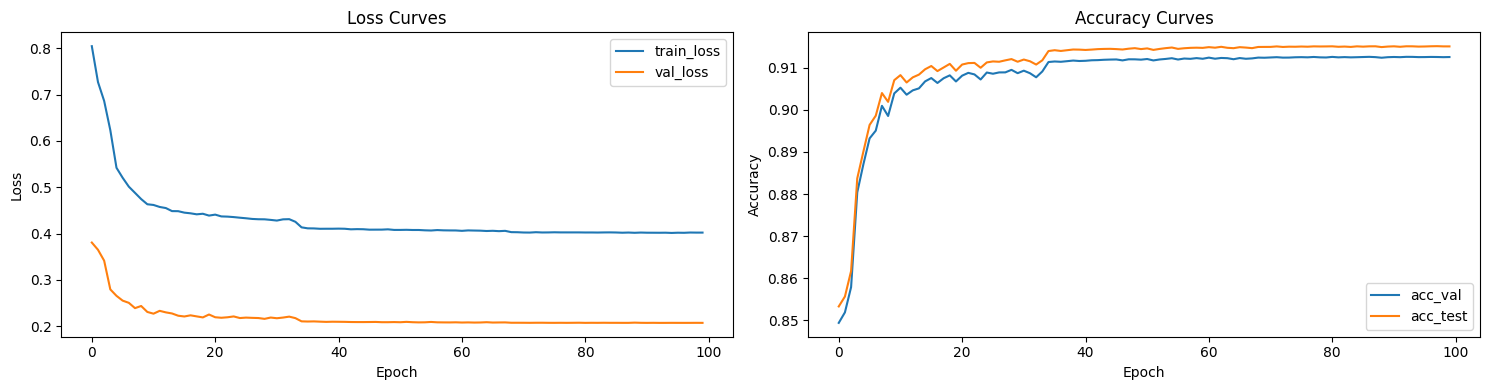

In [10]:
def train_euclidnet(n_layers, target_params):
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Training n_layers={n_layers}, target_params={target_params}")

    def objective(h):
        hparams = {
            "n_input": 3,      # 3D Coordniates
            "n_output": 1,     # edge classification result
            "n_hidden": int(h),
            "n_layers": n_layers,
            "c_weight": 1.0
        }
        return count_parameters(EuclidNet(hparams)) - target_params

    optimal_h = int(root_scalar(objective, bracket=[1, 1000], method='bisect').root)

    # Find hidden_size that suit #parameter
    candidates = {optimal_h-1, optimal_h, optimal_h+1}
    best_h = min(candidates, key=lambda h: abs(objective(h)) if h > 0 else float('inf'))

    hparams = {
        "n_input": 3,
        "n_output": 1,
        "n_hidden": best_h,
        "n_layers": n_layers,
        "c_weight": 1.0
    }

    model = EuclidNet(hparams).to(device)
    print(f"Actual amount of parameter: {count_parameters(model)}")

    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0, 0
    stats = []
    best = None

    #Train info
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)

    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)
        preds_val, actuals_val, acc_val, val_loss = evaluate(model, loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model, loader_test)

        stats.append({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'acc_val': acc_val,
            'acc_test': acc_test
        })

        if val_loss < best_val_loss:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {
                'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                'preds_test': preds_test,
                'preds_val': preds_val,
                'hparams': hparams
            }
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1

        # Early stop
        if epochs_no_improve >= TOLERANCE:
            print(f"Early stop at {epoch+1} round")
            break

        # Show declining LR
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >= 1.0e-8:
                lr /= 10
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                print(f"LR decreases to {lr}")
                epochs_no_improve2 = 0

    best['stats'] = stats

    # Save results to pkl files
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"euclidnet_{n_layers}_{target_params}.pkl"))

    # Training curves
    stats_df = pd.DataFrame(stats)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    stats_df[['train_loss', 'val_loss']].plot(ax=ax1, title='Loss Curves')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    stats_df[['acc_val', 'acc_test']].plot(ax=ax2, title='Accuracy Curves')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

    # Clear Cache
    del model, optimizer
    gc.collect()
    torch.cuda.empty_cache()

    return best

# Training!
for n_layers in tqdm([2,3,4]):
    for target_params in tqdm([100_000, 500_000, 1_000_000]):
        train_euclidnet(n_layers, target_params)

# Summary of Results

In [ ]:
val = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))

if isinstance(val, list):
    val_y = torch.cat([i.y for i in val]).numpy()
    test_y = torch.cat([i.y for i in test]).numpy()
else:
    val_y = torch.cat([i.y for i in val.values()]).numpy()
    test_y = torch.cat([i.y for i in test.values()]).numpy()

EuclidNet with Virtual Node Results Summary:
                 test_accuracy  val_accuracy
#layers #params                             
3       1000000       0.918964      0.916568
4       1000000       0.915095      0.912592
        500000        0.912416      0.909838
        100000        0.910520      0.908033
2       1000000       0.898684      0.895602
        100000        0.883048      0.879917
3       500000        0.880958      0.878139
        100000        0.881019      0.878011
2       500000        0.880322      0.877210

Best model test accuracy: 0.918964
Best model validation accuracy: 0.916568


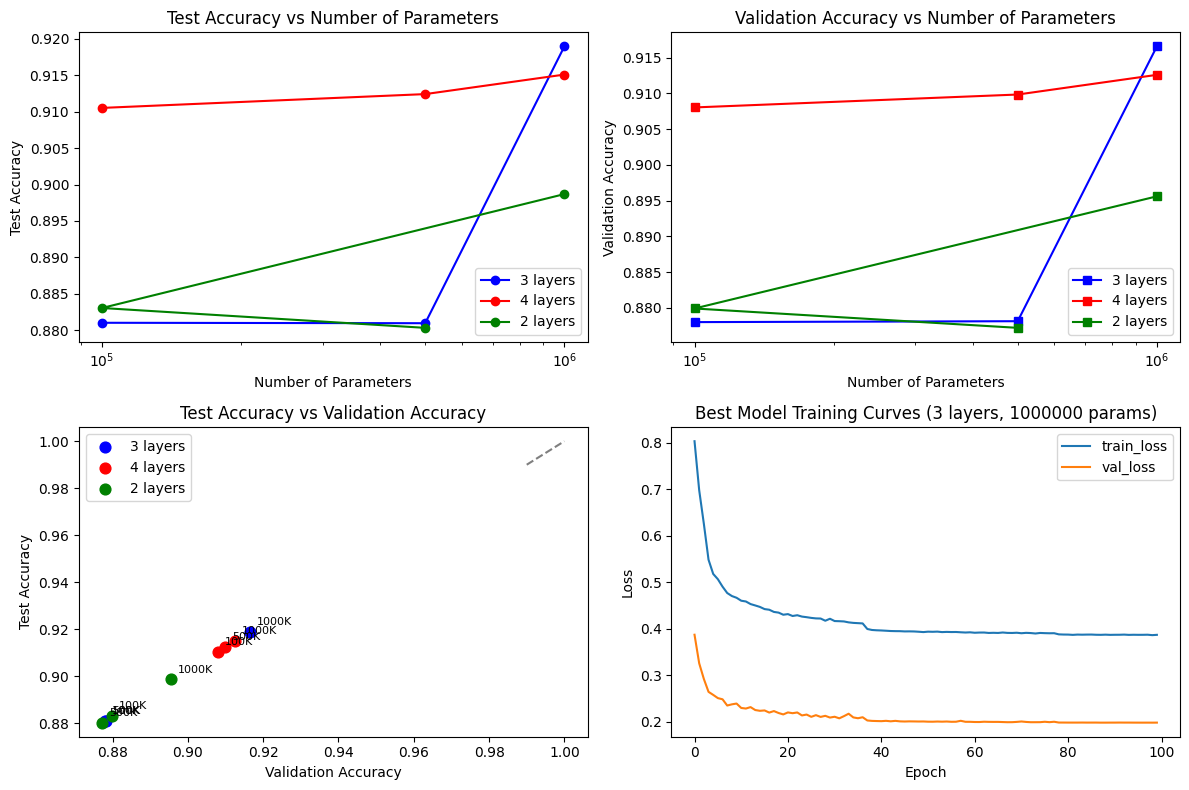

In [4]:
# Load validation and test set ground truth labels
val_data = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test_data = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
val_y = torch.cat([graph.y for graph in val_data]).numpy()
test_y = torch.cat([graph.y for graph in test_data]).numpy()

# Collect all results
results = {}
for pkl_file in glob(os.path.join(PATH_DATA, 'euclidnet_*.pkl')):
    result = joblib.load(pkl_file)
    preds_test = (result['preds_test'] >= 0.5)
    preds_val = (result['preds_val'] >= 0.5)

    filename = os.path.basename(pkl_file).replace('.pkl', '')
    results[filename] = {
        'test_accuracy': (preds_test == test_y).astype(float).mean(),
        'val_accuracy': (preds_val == val_y).astype(float).mean()
    }

# Convert to DataFrame and sort
results_df = pd.DataFrame(results).T.sort_values('val_accuracy', ascending=False)

# Parse filenames into multi-level index
index_tuples = []
for filename in results_df.index:
    parts = filename.split('_')
    n_layers = parts[1]
    n_params = parts[2]
    index_tuples.append((n_layers, n_params))

results_df.index = pd.MultiIndex.from_tuples(index_tuples, names=['#layers', '#params'])

# Save results
results_df.to_csv(os.path.join(PATH_DATA, 'euclidnet_results.csv'))

# print("EuclidNet Results Summary:")
print("EuclidNet with Virtual Node Results Summary:")

print(results_df)

# Print best results
best_result = results_df.iloc[0]
print(f"\nBest model test accuracy: {best_result['test_accuracy']:.6f}")
print(f"Best model validation accuracy: {best_result['val_accuracy']:.6f}")

# Plot results visualization
plt.figure(figsize=(12, 8))

# Plot grouped by number of layers
layers = results_df.index.get_level_values(0).unique()
colors = ['blue', 'red', 'green', 'orange']

for i, layer in enumerate(layers):
    layer_data = results_df.loc[layer]
    params = [int(p) for p in layer_data.index]
    test_acc = layer_data['test_accuracy'].values
    val_acc = layer_data['val_accuracy'].values

    plt.subplot(2, 2, 1)
    plt.plot(params, test_acc, 'o-', color=colors[i], label=f'{layer} layers')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs Number of Parameters')
    plt.legend()
    plt.xscale('log')

    plt.subplot(2, 2, 2)
    plt.plot(params, val_acc, 's-', color=colors[i], label=f'{layer} layers')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Number of Parameters')
    plt.legend()
    plt.xscale('log')

plt.subplot(2, 2, 3)
for i, layer in enumerate(layers):
    layer_data = results_df.loc[layer]
    params = [int(p) for p in layer_data.index]
    test_acc = layer_data['test_accuracy'].values
    val_acc = layer_data['val_accuracy'].values

    plt.scatter(val_acc, test_acc, color=colors[i], label=f'{layer} layers', s=60)

    # Add parameter count annotations
    for j, (v, t, p) in enumerate(zip(val_acc, test_acc, params)):
        plt.annotate(f'{p//1000}K', (v, t), xytext=(5, 5),
                    textcoords='offset points', fontsize=8)

plt.xlabel('Validation Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Validation Accuracy')
plt.legend()
plt.plot([0.99, 1.0], [0.99, 1.0], 'k--', alpha=0.5)

plt.subplot(2, 2, 4)
# Show training curves for best configuration
best_config = results_df.index[0]
best_file = f"euclidnet_{best_config[0]}_{best_config[1]}.pkl"
best_result = joblib.load(os.path.join(PATH_DATA, best_file))
best_stats = pd.DataFrame(best_result['stats'])

best_stats[['train_loss', 'val_loss']].plot(ax=plt.gca())
plt.title(f'Best Model Training Curves ({best_config[0]} layers, {best_config[1]} params)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()